## keras_ocr

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [2]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


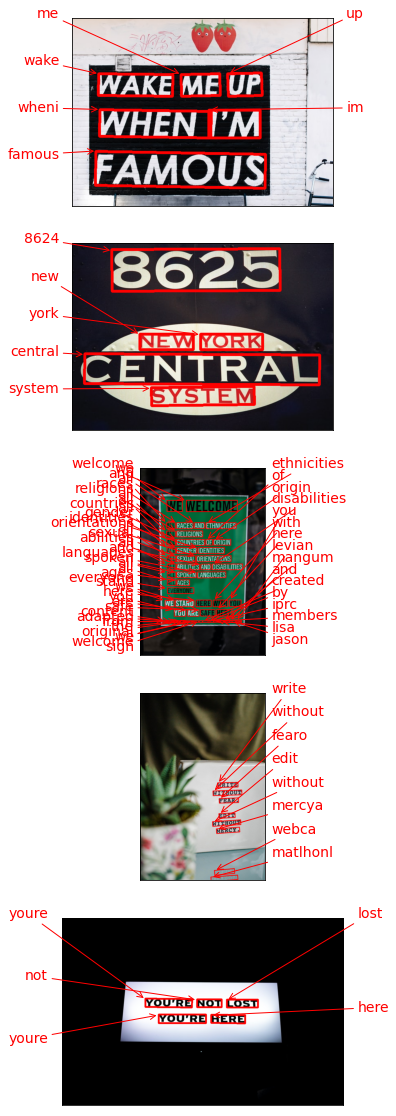

In [3]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 1) 테서랙트 설치하기

클라우드 쉘에서 아래 코드를 사용해 테서랙트 관련 패키지들을 설치해 주세요.

In [8]:
! sudo apt install tesseract-ocr -y
! sudo apt install libtesseract-dev -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 0 not upgraded.
Need to get 7,031 kB of archives.
After this operation, 22.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libopenjp2-7 amd64 2.3.0-2build0.18.04.1 [145 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 liblept5 amd64 1.75.3-3 [929 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract4 amd64 4.00~git2288-10f4998a-2 [1,163 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:5 http://archive.ubuntu.c

### 2) 테서랙트 파이썬 wrapper 설치하기

Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)입니다. 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줍니다.

    Pytesseract
    위키백과: 래퍼 라이브러리

클라우드 컨테이너에는 이미 설치가 되어 있으니 확인 후 진행해 주세요

$ pip list | grep pytesseract

만약 설치가 안 되어 있다면 아래 명령어를 이용해 설치하세요.

$ pip install pytesseract

3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)

테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데요. 우리는 OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해 봅시다.

In [7]:
!pip list | grep pytesseract

pytesseract                   0.3.7
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [9]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/lms.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png
/aiffel/aiffel/ocr_python/0020.png
/aiffel/aiffel/ocr_python/0021.png
/aiffel/aiffel/ocr_python/0022.png
/aiffel/aiffel/ocr_python/0023.png
/aiffel/aiffel/ocr_python/0024.png
/aiffel/aiffel/ocr_python/0025.png
/aiffel/aiffel/ocr_python/0026.png
/aiffel/aiffel/ocr_python/0027.png
/aiffel/aiffel/ocr_p

위에서 구현한 crop_word_regions() 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다.

기본적으로 pytesseract.image_to_data() 를 사용합니다. 파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결괏값의 형식을 딕셔너리(DICT) 형식으로 설정해 주게 됩니다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 됩니다. 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴하였습니다.

(주의) 위 코드에서 lang='kor' 로 바꾸면 에러가 발생합니다. 테서랙트의 언어팩을 설치해야 정상 동작하게 됩니다.

$ sudo apt install tesseract-ocr-kor

언어팩 설치 관련해서는 이 페이지를 참고해 주세요.
4) 테서랙트로 잘린 이미지에서 단어 인식하기

이제 문자 인식을 해 볼 차례입니다. 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 image_to_string()를 사용하게 됩니다.

이렇게 인식된 결과가 실제 이미지와 맞는지 확인해 봅시다.

In [12]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [13]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)



/

i wa i




nttos://Ims.aitfelio/steps2/1527

ttyd

te

Terminal

-

Microsort

Fage

a

nttps://8887-ws27a03cbo6/771

1zpmitpcntz.cl.prod.connect.ainize.al,


a

eT i

| A, hitps://8887-ws27a03cb0877i zpmitpahfz.ct.prod.connectainize.ai/ ey OO

212 OIRILICL BETAS

= —

or}

2

ATOHAG

TO)

7ocs

=>

on

=>

Oo}

o1A/ X10]

=A |

mia

Bere

7 AFOUL Ag

one]

AI

OFL| =FL} Cr.

3t-—

me eric.

ef =

Oj AIS

FAS

(Kernel) 0/22

== ,!

O}=LICt.


= (|

BOVAILFR ?

DAC

OFOF

04 23

== (|

Aq? I

( =

LMS

4 42or!

ALT


(A?

p28

TO —————————————————————————————————————————

Forum

User

ll

[ © 07:11:05 Forum jee )

eaijtoro


=

at | APS?

— |

T ee |

Y= GA

0-4.

Fj

SI Shot)

= 1G

ra

|

T

ier

+s > a

FR} O7

rLiSTLiCp

af i JI

os Al &

rL

~eclill

|

ib eT

=—corvi

IMS

ae ES oP oe AT

AF AT

PO] “t

zs

== 0 OF


~~

Si eslile

OrAlVE

PO] 4P

a7 h JP

a ee

Sepa A



## 18-9. 프로젝트 : 다양한 OCR모델 비교하기

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

Step1. 검증용 데이터셋 준비

OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

Step3. 테스트 결과 정리

모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

Step4. 결과 분석과 결론 제시

    우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
    여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다.
    그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

## 신용카드 가입이 찝찝해서 구글 빼고 케라스와 테서랙트만 진행하겠습니다

## keras

In [14]:
path = os.getenv('HOME')+'/aiffel/ocr_python/data/'
image_urls = ['4.jpg','5.jpg','6.jpg','7.jpg','8.jpg','9.jpg']

In [27]:
images = [ keras_ocr.tools.read(path+url) for url in image_urls]
prediction_groups = [pipeline.recognize([path+url]) for url in image_urls]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


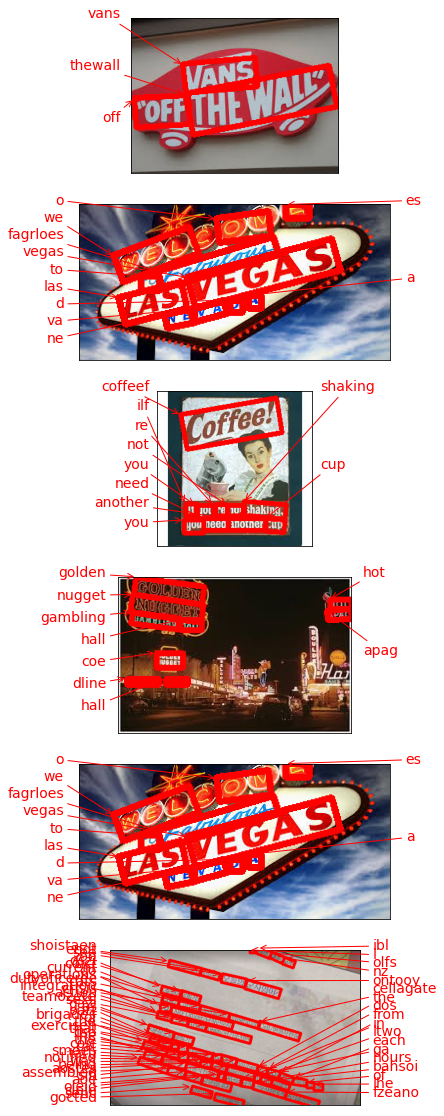

In [28]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

영어로 하니 확연히 나은 결과를 보인다

###  웹의 버튼 그림에서 문자를 잘 인식하나를 보기위해 그림변경

In [17]:
path = os.getenv('HOME')+'/aiffel/ocr_python/data/'
img_list = []
for filename in os.listdir(path):
    img_list.append(path + filename)
print(img_list)

['/aiffel/aiffel/ocr_python/data/9.jpg', '/aiffel/aiffel/ocr_python/data/c.png', '/aiffel/aiffel/ocr_python/data/a.png', '/aiffel/aiffel/ocr_python/data/8.jpg', '/aiffel/aiffel/ocr_python/data/f.png', '/aiffel/aiffel/ocr_python/data/g.png', '/aiffel/aiffel/ocr_python/data/e.png', '/aiffel/aiffel/ocr_python/data/b.png', '/aiffel/aiffel/ocr_python/data/7.jpg', '/aiffel/aiffel/ocr_python/data/d.png']


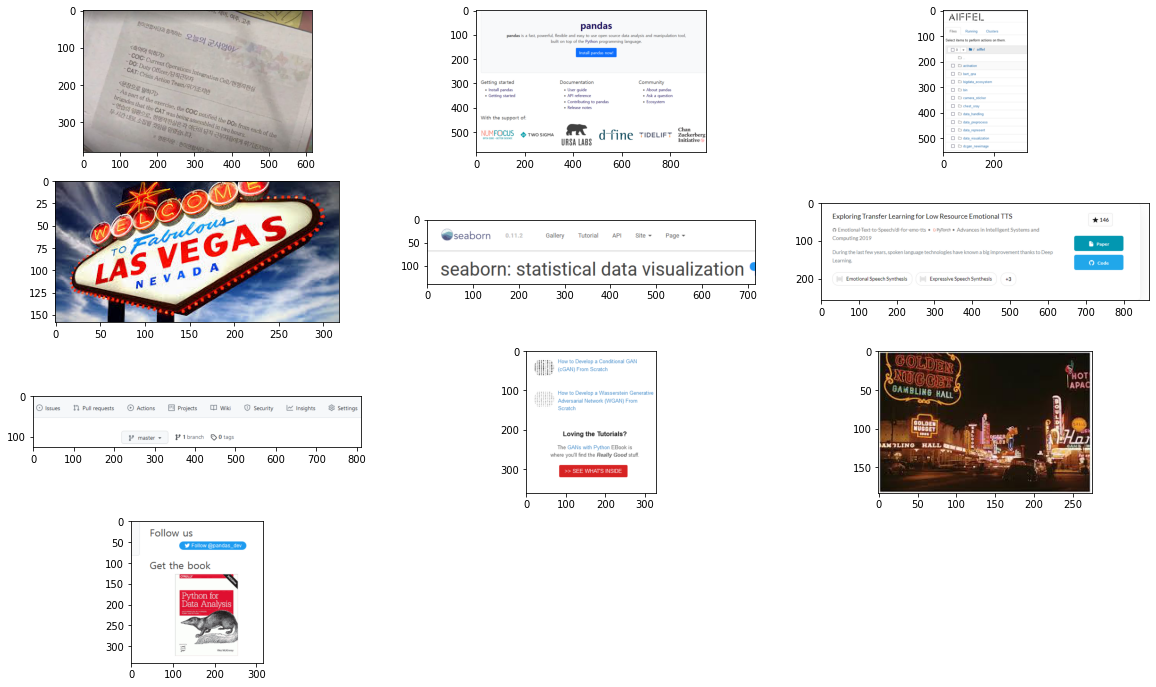

In [21]:
import matplotlib.image as img

plt.figure(figsize = (20, 12))

for i in range(len(img_list)):
    plt.subplot(4, 3, i+1)
    imgs = img.imread(img_list[i])
    plt.imshow(imgs)

plt.show()

In [19]:
images = [ keras_ocr.tools.read(url) for url in img_list]
prediction_groups = [pipeline.recognize([url]) for url in img_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


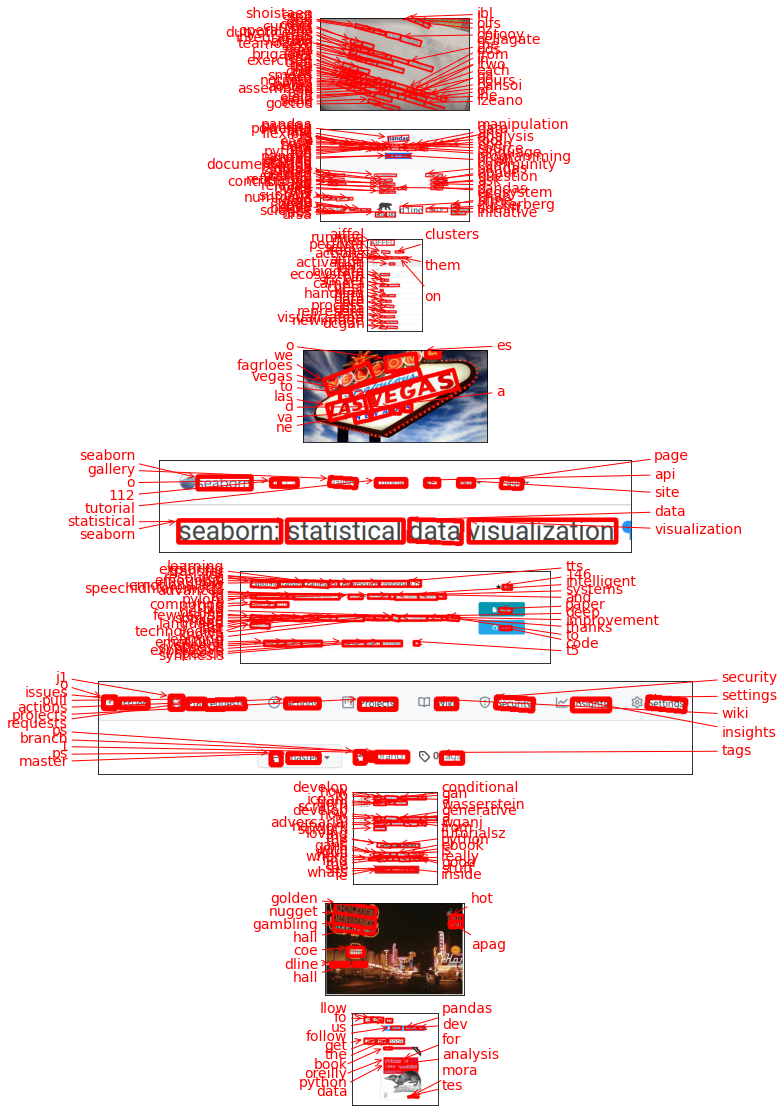

In [20]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

이미지 사이즈를 너무 작은걸 골랐더니 알아보기가 힘들다   
그래도 웹상의 이미지의 글씨를 대부분 잘 인식하고 있다

## 테서랙트

In [22]:
print(img_list)

['/aiffel/aiffel/ocr_python/data/9.jpg', '/aiffel/aiffel/ocr_python/data/c.png', '/aiffel/aiffel/ocr_python/data/a.png', '/aiffel/aiffel/ocr_python/data/8.jpg', '/aiffel/aiffel/ocr_python/data/f.png', '/aiffel/aiffel/ocr_python/data/g.png', '/aiffel/aiffel/ocr_python/data/e.png', '/aiffel/aiffel/ocr_python/data/b.png', '/aiffel/aiffel/ocr_python/data/7.jpg', '/aiffel/aiffel/ocr_python/data/d.png']


In [23]:
cropped_image_path_list = [crop_word_regions(url, path+'7')for url in img_list]

/aiffel/aiffel/ocr_python/data/7/0000.png
/aiffel/aiffel/ocr_python/data/7/0000.png
/aiffel/aiffel/ocr_python/data/7/0001.png
/aiffel/aiffel/ocr_python/data/7/0002.png
/aiffel/aiffel/ocr_python/data/7/0003.png
/aiffel/aiffel/ocr_python/data/7/0004.png
/aiffel/aiffel/ocr_python/data/7/0005.png
/aiffel/aiffel/ocr_python/data/7/0006.png
/aiffel/aiffel/ocr_python/data/7/0007.png
/aiffel/aiffel/ocr_python/data/7/0008.png
/aiffel/aiffel/ocr_python/data/7/0009.png
/aiffel/aiffel/ocr_python/data/7/0010.png
/aiffel/aiffel/ocr_python/data/7/0011.png
/aiffel/aiffel/ocr_python/data/7/0012.png
/aiffel/aiffel/ocr_python/data/7/0013.png
/aiffel/aiffel/ocr_python/data/7/0014.png
/aiffel/aiffel/ocr_python/data/7/0015.png
/aiffel/aiffel/ocr_python/data/7/0016.png
/aiffel/aiffel/ocr_python/data/7/0017.png
/aiffel/aiffel/ocr_python/data/7/0018.png
/aiffel/aiffel/ocr_python/data/7/0019.png
/aiffel/aiffel/ocr_python/data/7/0020.png
/aiffel/aiffel/ocr_python/data/7/0021.png
/aiffel/aiffel/ocr_python/data/7/0

In [24]:
[recognize_images(i)for i in cropped_image_path_list]

Follow

Done
Follow

US

Paonia

(,eT

the

DOoOoK

Pytno!

ee):

Dale

Analvsis


ce

Jevelop

4

VVasserstein

(senerative

Ariversarial

Network

VVGAN})

rom

“cratcn


Loving

rhe

Tutoriais ?

lhe

eri

s with

Python

— 00

kK IS

where

youll

nnd

the

neally

(s00

gq stu

pea Nea SOS

synthesis

Expressive

Speech

synthesis

+4

¥% 146

C) Code

Documentation

—

Liser

guide

—

API

reference

—

Contributing

TO

pandas

—

Release

noTes

or

d+

IRSA

1 ABS

ine

Community

—

About

pandas

—

Ask

ca

question

—

rcosystem

Chan

+ IDWELIF :

Zuckerberg

Initiative

“iy

Done
Follow

US

Paonia

(,eT

the

DOoOoK

Pytno!

ee):

Dale

Analvsis


ce

Jevelop

4

VVasserstein

(senerative

Ariversarial

Network

VVGAN})

rom

“cratcn


Loving

rhe

Tutoriais ?

lhe

eri

s with

Python

— 00

kK IS

where

youll

nnd

the

neally

(s00

gq stu

pea Nea

[None, None, None, None, None, None, None, None, None, None]

한번에 했더니 뭐가 뭔지 모르겠다

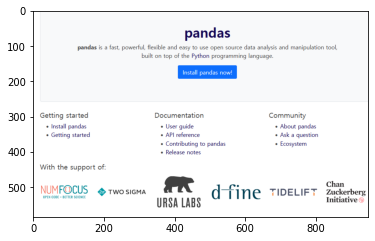

In [26]:
imgs = img.imread(img_list[1])
plt.imshow(imgs)

In [34]:
crop_list = crop_word_regions(img_list[1], path+'8')
recognize_images(crop_list)

/aiffel/aiffel/ocr_python/data/8/0000.png
/aiffel/aiffel/ocr_python/data/8/0001.png
/aiffel/aiffel/ocr_python/data/8/0002.png
/aiffel/aiffel/ocr_python/data/8/0003.png
/aiffel/aiffel/ocr_python/data/8/0004.png
/aiffel/aiffel/ocr_python/data/8/0005.png
/aiffel/aiffel/ocr_python/data/8/0006.png
/aiffel/aiffel/ocr_python/data/8/0007.png
/aiffel/aiffel/ocr_python/data/8/0008.png
/aiffel/aiffel/ocr_python/data/8/0009.png
/aiffel/aiffel/ocr_python/data/8/0010.png
/aiffel/aiffel/ocr_python/data/8/0011.png
/aiffel/aiffel/ocr_python/data/8/0012.png
/aiffel/aiffel/ocr_python/data/8/0013.png
/aiffel/aiffel/ocr_python/data/8/0014.png
/aiffel/aiffel/ocr_python/data/8/0015.png
/aiffel/aiffel/ocr_python/data/8/0016.png
/aiffel/aiffel/ocr_python/data/8/0017.png
/aiffel/aiffel/ocr_python/data/8/0018.png
/aiffel/aiffel/ocr_python/data/8/0019.png
/aiffel/aiffel/ocr_python/data/8/0020.png
/aiffel/aiffel/ocr_python/data/8/0021.png
/aiffel/aiffel/ocr_python/data/8/0022.png
/aiffel/aiffel/ocr_python/data/8/0

바꿔가며 시험해본 결과 테서렉트는 평면적 문서 대응은 좋지만 각도가 옆으로 하는 입간판 같은 것을 인식하는데 약해보인다

No.|평가문항|상세기준
-|:-|:-
1.|OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|	목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
2.| 모델 평가기준이 명확하고 체계적으로 세워졌는가?|	평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
3.| 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|	최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

## 루브릭 답변
1. 구상하는 서비스는 인터넷 예약 시도 매크로, 웹크롤링으로는 이미지가 들어가있는 사이트에 대처할수 없기때문에
    그림의 텍스트 인식을 위해 OCR이 필요
2. 한글을 잘 인식할 수 있는가. 잘 못한다. 외국의 OCR은 lang=kor로 바꿔주어도 거의 검출하지 못했다. 그래서 현재 실험가능한 상황에 맞게 영어 사이트로 다시 시험할 계획이다. 영어 사이트 사진을 잘라서 가져온 결과 인식 및 언어 변환률이 좋다
3. 결론 - 케라스는 여러 각도의 문자도 잘 안식했지만 문자 변환의 미흡함을 보였고
    테서렉트는 평면적인 문자만 잘 인식하고 문자 변환도 별로였다

## 회고
- 잘돌아가는데 한글 데이터라 데이터가 엉망이다. 특히 테서렉트는 한글까지 깔아줬는데 엉망
- 해보기전에는 ocr왜이리 후지냐고 욕했는데 유명제품이 이정도라니 갈길이 멀다 ㅠㅠ 

##  한글 결과물 (다 kor로 바꿔줬는데 소용없다)

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


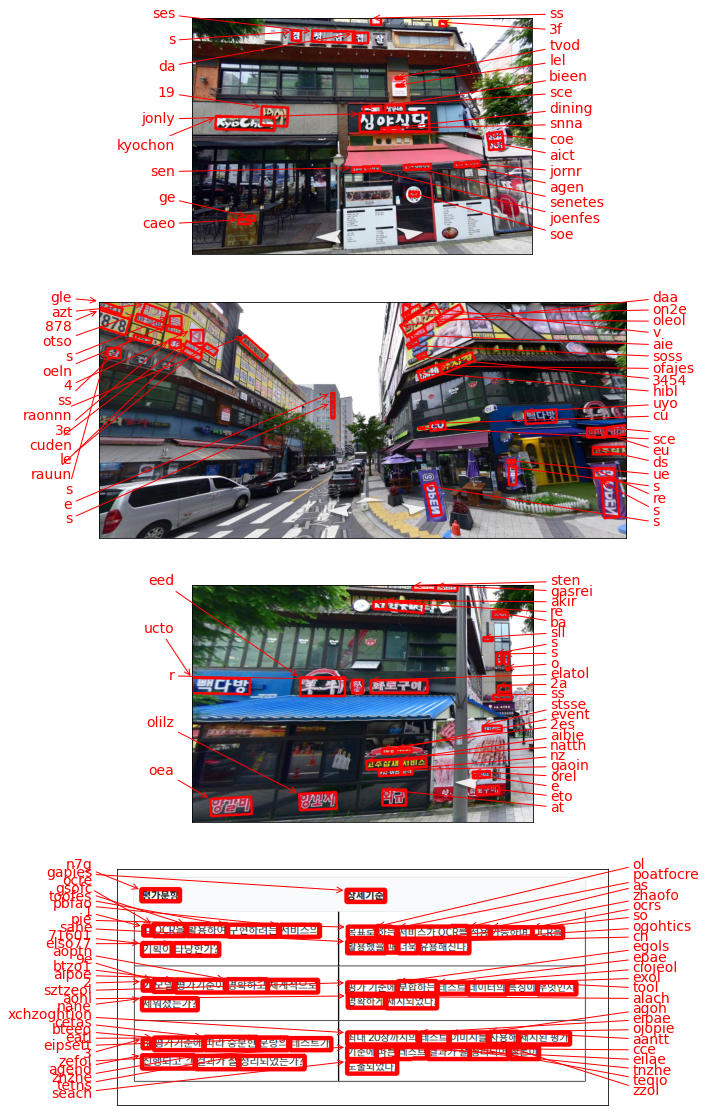

In [15]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

한글로 시도했는데 엉망인 결과를 뱉는거 빼고 글자는 잘찾는다

In [23]:
[recognize_images(i)for i in cropped_image_path_list]

쓰

Done
쓰

Done
쓰

/

무항

1] ()(

을

왕

폭

하여

그

03

아려는

서

비

~ 2


기

의

Done
쓰

/

무항

1] ()(

을

왕

폭

하여

그

03

아려는

서

비

~ 2


기

의

[)

| 타

나

이

[7

상

세

기준

곡

ㄷㄷ

= 0  =

아=

서

비

~ /

;

()

(_

= 0  =

들

석욕

/

[등

아

너

,

[)( |}?

글

왁

을

했을

대

더욱

= 0  =

보유

애신나.

나으

/

. 모델

| 평

/

[기

ㅡ

[)

| 명

와

하고

세

겨

석

이2 로

세

위

션

느가?

펴 7

| 7

주

에

무

암

하=

테스트

데

10

|터

의


식

()

| 무

21

01 시

떠

오

하거

| 제

시

되었다.

나으


4

.평

/

2)

수

개

| 따르

| 충분한

[| 문

ㄴㄴ 》

의

테

에

드 /

[

신

앵

되 고

」

설

과

가

살

성

그

되었는가?


쇠대

= 0  =

2(0)삼

까

시

의

테스트

()

미

시

들

사용해

제시된

평가

기

구겨

에

다른

테스트

7

과

가

살

석

「-

되어

설

로

()

누

숙

되었다.

2022222--------------------------------------------------ㅠ=


Done


[None, None, None, None]

테서렉트는 한글을 읽기는한데 영 좋지않다